In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.risk.risk_type import RiskType
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep

In [4]:
## Database Declarations
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

In [6]:
## Retrieve previously calculated Macro Projections
fred.connect()
sp500 = p.lower_column(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
sp500 = p.utc_date(sp500)
interest_rates = p.lower_column(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates = p.utc_date(interest_rates)
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect()
macro = sp500.merge(interest_rates,on="date",how="left")

In [7]:
## Retrieve and set up factors for modeling

## Feel free to add additional tickers you would like to use for modeling
factors = ["AMZN","NVDA","AAPL","META","GOOGL","TSLA","MSFT"]
market.connect()
factors_df = []
for ticker in tqdm(factors):
    try:
        price = p.lower_column(market.query("prices",{"ticker":ticker}))
        price = p.utc_date(price)
        price.sort_values("date")
        price["adjclose"] = price["adjclose"].shift(60)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
factors_df = pd.concat(factors_df).sort_values("date").pivot_table(index=["date"],columns="ticker",values="adjclose").reset_index()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.25it/s]


In [8]:
## Defining years for modeling and backtesting feel free to change these
model_start = 2015
model_end = 2022
backtest_end = 2026

In [9]:
market.connect()
prices = []

for ticker in tqdm(index["ticker"]): 
    try:## price prep
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            ## factor merge and indicator calculations
            price = factors_df.merge(price[["date", "ticker", "adjclose", "adjhigh", "adjlow", "adjvolume"]], on="date", how="left")
            price = p.additional_date_columns(price)
            price = Indicator.ROLLING_DOLLAR_VOLUME.calculate(price)
            
            price["y"] = price["adjclose"].shift(-60)
    
            ## subsetting training and modeling data
            training_data = price[(price["year"] >= model_start) & (price["year"] < model_end)].dropna(subset=factors).dropna()
            sim = price[(price["year"] >= model_end - 1) & (price["year"] < backtest_end)].dropna(subset=factors)
            if training_data.index.size >200 and sim.index.size >200:
                ## Modeling and Projections
                model = XGBRegressor()
                model.fit(training_data[factors], training_data["y"])
                sim["prediction"] = model.predict(sim[factors])
        
                ## Risk Application
                sim = sim.merge(macro, on="date", how="left")
                sim = SingleIndexCAPM.apply(sim)
                for member in RiskType:
                    sim = member.apply(sim)
                
                prices.append(sim)
    except Exception as e:
        # Print the exception message for debugging, continue processing the next ticker
        print(str(e))
        continue

market.disconnect()

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 81/87 [00:12<00:01,  5.10it/s]E:\projects\orivault\financial_common\risk\single_index_capm.py:18: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["historical_return"] = df["adjclose"].pct_change(60)
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 83/87 [00:12<00:00,  6.73it/s]E:\projects\orivault\financial_common\risk\single_index_capm.py:18: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling 

In [10]:
## getting names
simulation = pd.concat(prices).merge(index[["ticker","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]
simulation.columns

Index(['date', 'AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA',
       'ticker', 'adjclose', 'adjhigh', 'adjlow', 'adjvolume', 'year', 'month',
       'quarter', 'week', 'reference_price', 'reference_volume',
       'reference_high', 'reference_low', 'rolling_dollar_volume', 'y',
       'realtime_start', 'realtime_end', 'rf', 'factor', 'risk', 'sigma',
       'coefficient_of_variation', 'drawdown', 'market_cap', 'office',
       'sic_description', 'sell_price', 'sell_date'],
      dtype='object')

In [11]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [12]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.01])

In [13]:
run = True
if run:
    analysises = []
    for portfolio in tqdm(portfolios):
        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = Metrics.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 152/216 [02:25<01:01,  1.05it/s]


KeyboardInterrupt: 

In [14]:
a = pd.DataFrame(analysises)
a.columns

Index(['timeframe', 'ranking_metric', 'position_type', 'grouping_type',
       'selection_type', 'allocation_type', 'risk_type',
       'selection_percentage', 'date', 'pnl', 'coefficient_of_variation',
       'portfolio_std', 'average_gain', 'average_loss', 'win_loss_ratio',
       'weekly_return', 'sharpe_ratio', 'portfolio'],
      dtype='object')

In [15]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

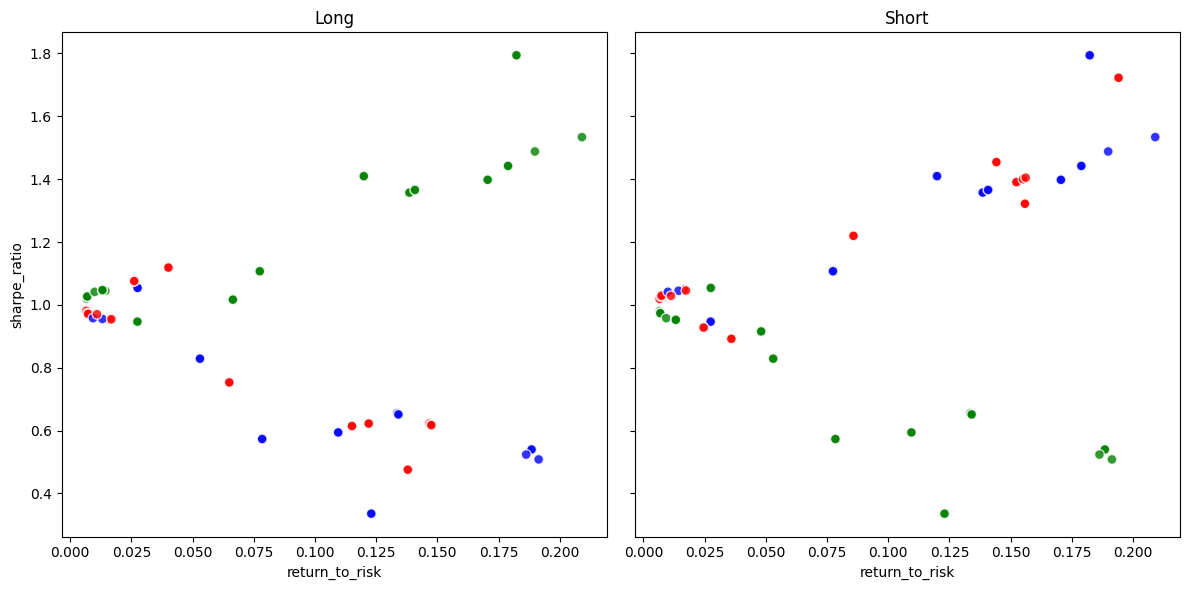

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        s=50,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [17]:
a.groupby("pnl").first().reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,pnl,timeframe,ranking_metric,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,color,return_to_risk
67,1.794319,quarter,factor,long,OFFICE,mixed,equal,coefficient_of_variation,0.01,9.842056,0.182311,1.216425,0.788437,0.561538,1.028769,-0.610972,<financial_common.portfolio_management.portfol...,green,9.842056
66,1.722647,quarter,factor,short,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.01,8.875278,0.194095,1.155481,0.855024,0.544025,1.018480,-0.943142,<financial_common.portfolio_management.portfol...,red,8.875278
65,1.533849,quarter,factor,long,OFFICE,mixed,risk,coefficient_of_variation,0.01,7.336859,0.209061,1.028218,0.980155,0.561538,1.007144,-1.778700,<financial_common.portfolio_management.portfol...,green,7.336859
64,1.488099,quarter,factor,long,OFFICE,mixed,risk,drawdown,0.01,7.838178,0.189853,1.026136,0.977430,0.561538,1.004780,-2.199635,<financial_common.portfolio_management.portfol...,green,7.838178
63,1.454368,quarter,factor,short,OFFICE,bottom,equal,coefficient_of_variation,0.01,10.086231,0.144193,1.203421,0.827502,0.546154,1.032811,-3.130083,<financial_common.portfolio_management.portfol...,red,10.086231
62,1.442122,quarter,factor,long,OFFICE,mixed,market_cap,coefficient_of_variation,0.01,8.061928,0.178881,1.021678,0.978052,0.553846,1.002214,-2.591583,<financial_common.portfolio_management.portfol...,green,8.061928
61,1.409677,quarter,factor,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.01,11.751545,0.119957,1.145538,0.848818,0.526730,1.005109,-4.135060,<financial_common.portfolio_management.portfol...,green,11.751545
60,1.404704,quarter,factor,short,SIC_DESCRIPTION,bottom,risk,drawdown,0.01,8.994211,0.156179,1.004378,0.997036,0.544025,1.001030,-3.207878,<financial_common.portfolio_management.portfol...,red,8.994211
59,1.399902,quarter,factor,short,SIC_DESCRIPTION,bottom,risk,coefficient_of_variation,0.01,9.027770,0.155066,1.003904,0.997028,0.544025,1.000769,-3.261860,<financial_common.portfolio_management.portfol...,red,9.027770
58,1.397941,month,factor,long,OFFICE,mixed,equal,coefficient_of_variation,0.01,8.196819,0.170547,1.115514,0.888649,0.541026,1.011389,-2.053875,<financial_common.portfolio_management.portfol...,green,8.196819


In [18]:
top = a.sort_values("pnl",ascending=False).head(1).to_dict("records")[0]
top

{'timeframe': 'quarter',
 'ranking_metric': 'factor',
 'position_type': 'short',
 'grouping_type': 'OFFICE',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'drawdown',
 'selection_percentage': 0.01,
 'date': Timestamp('2025-03-20 00:00:00+0000', tz='UTC'),
 'pnl': 1.7943188126583751,
 'coefficient_of_variation': 9.842056453912056,
 'portfolio_std': 0.1823113717199989,
 'average_gain': 1.216424969643812,
 'average_loss': 0.7884374798405629,
 'win_loss_ratio': 0.5615384615384615,
 'weekly_return': 1.0287689164223874,
 'sharpe_ratio': -0.6109717030425684,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x24869bc3e10>,
 'color': 'blue',
 'return_to_risk': 9.842056453912056}

In [20]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","office","sic_description"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

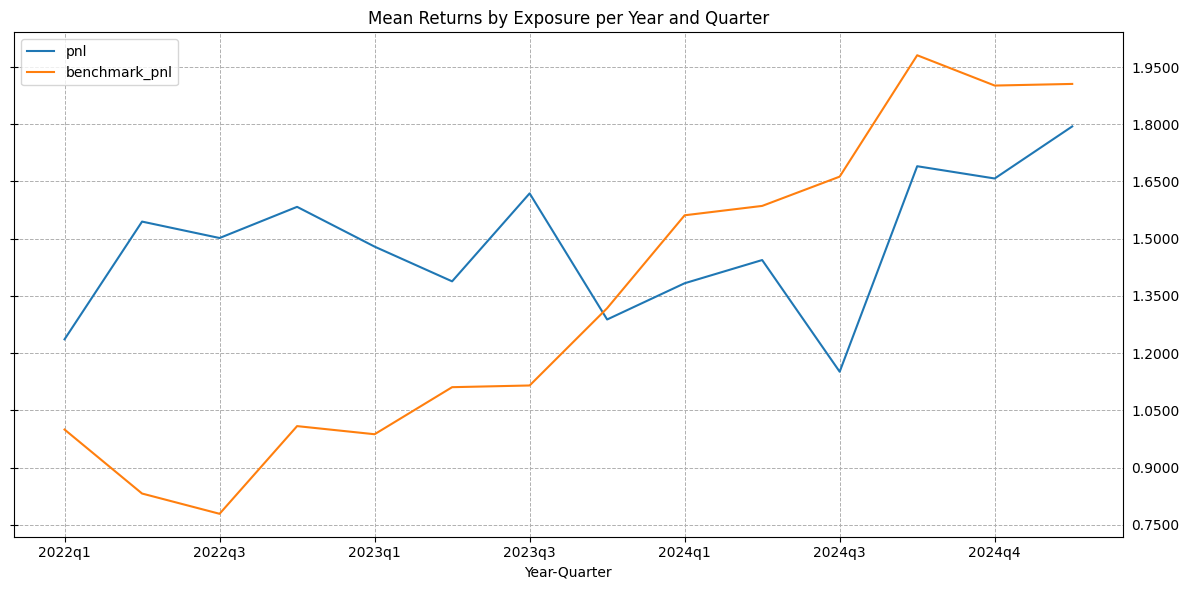

In [21]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [23]:
trades[["office","return"]].groupby("office").mean().sort_values("return",ascending=False)

,return
office,
Office of Trade & Services,1.131391
Office of Manufacturing,1.126256
Office of Energy & Transportation,1.067250
Industrial Applications and Services,1.044324
Office of Technology,1.008034
Office of Finance or Office of Crypto Assets,0.999079
Office of Real Estate & Construction,0.995610
Office of Finance,0.982611
Office of Trade & Services or Office of Energy & Transportation,0.977859
